<ipython-input-7-0e34b8faaccb>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Dates'])


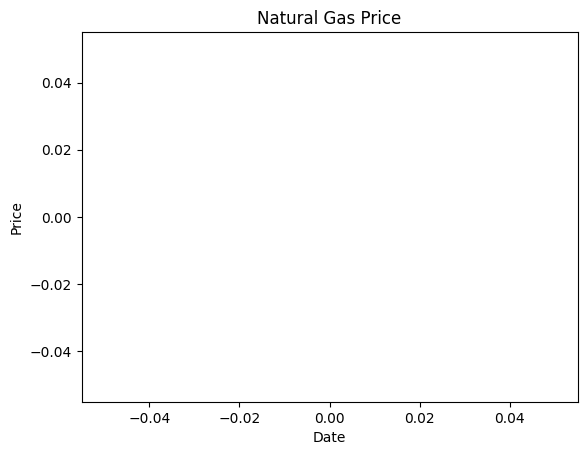

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94uord3l/vce_u8wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp94uord3l/7sdqkf8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7051', 'data', 'file=/tmp/tmp94uord3l/vce_u8wi.json', 'init=/tmp/tmp94uord3l/7sdqkf8n.json', 'output', 'file=/tmp/tmp94uord3l/prophet_model16b3fxu9/prophet_model-20250514090632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:06:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


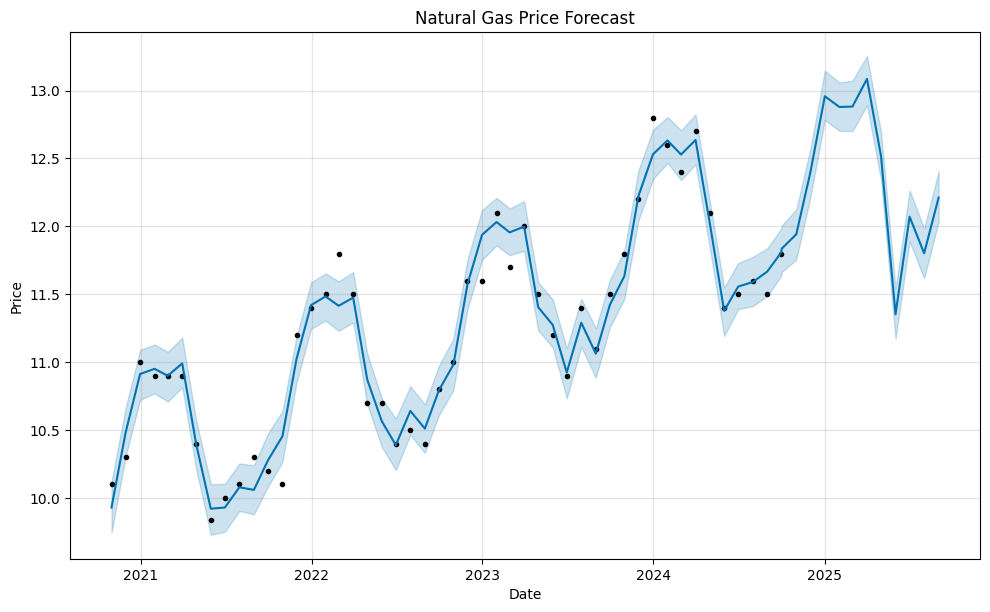

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load and preprocess data
df = pd.read_csv("Nat_Gas.csv")
df['Date'] = pd.to_datetime(df['Dates'])

# Prophet requires columns: ds (date) and y (value)
df_prophet = df.rename(columns={'Date': 'ds', 'Prices': 'y'})

# Create and fit model
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Create future dataframe for 12 more months
future = model.make_future_dataframe(periods=12, freq='MS')

# Forecast
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Natural Gas Price Forecast")
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

# Function to get price estimate for any date
def estimate_price(date_str):
    input_date = pd.to_datetime(date_str)

    # Check if date is already in forecast
    if input_date in forecast['ds'].values:
        return forecast[forecast['ds'] == input_date]['yhat'].values[0]
    else:
        # Interpolate between known points if within range
        all_forecast = forecast.set_index('ds')['yhat']
        all_forecast = all_forecast.sort_index().resample('D').interpolate('linear')
        if input_date in all_forecast.index:
            return all_forecast.loc[input_date]
        elif input_date < all_forecast.index[0]:
            return f"Date {input_date.date()} is before available data."
        elif input_date > all_forecast.index[-1]:
            return f"Forecast available only up to {all_forecast.index[-1].date()}"
        else:
            return "Could not estimate."



In [8]:
# Example usage
print("Interpolated price on 2023-07-15:", estimate_price('2023-07-15'))
print("Forecasted price on 2025-06-01:", estimate_price('2025-06-01'))

Interpolated price on 2023-07-15: 11.10156550589556
Forecasted price on 2025-06-01: 11.352768828729507


In [3]:
from datetime import timedelta

def price_gas_storage_contract(
    injection_dates,
    withdrawal_dates,
    injection_rate,
    withdrawal_rate,
    max_volume,
    storage_cost_per_day,
    estimate_price
):
    # Convert to datetime
    injection_dates = [pd.to_datetime(d) for d in injection_dates]
    withdrawal_dates = [pd.to_datetime(d) for d in withdrawal_dates]
    all_dates = sorted(set(injection_dates + withdrawal_dates))

    # Create timeline from first to last activity
    start = min(all_dates)
    end = max(all_dates)
    timeline = pd.date_range(start, end, freq='D')

    volume = 0
    total_value = 0
    volume_over_time = []

    for date in timeline:
        cash_flow = 0

        # Inject gas
        if date in injection_dates:
            inject_volume = min(injection_rate, max_volume - volume)
            price = estimate_price(date.strftime('%Y-%m-%d'))
            cash_flow -= inject_volume * price
            volume += inject_volume

        # Withdraw gas
        if date in withdrawal_dates:
            withdraw_volume = min(withdrawal_rate, volume)
            price = estimate_price(date.strftime('%Y-%m-%d'))
            cash_flow += withdraw_volume * price
            volume -= withdraw_volume

        # Storage cost
        storage_cost = volume * storage_cost_per_day
        cash_flow -= storage_cost

        total_value += cash_flow
        volume_over_time.append(volume)

    return {
        'Contract Value': round(total_value, 2),
        'Final Volume in Storage': volume,
        'Volume Over Time': volume_over_time,
        'Start Date': start,
        'End Date': end
    }


In [20]:
# Example usage
result = price_gas_storage_contract(
    injection_dates=pd.date_range('2024-10-01', '2024-10-15', freq='D'),
    withdrawal_dates=pd.date_range('2025-01-10', '2025-01-20', freq='D'),
    injection_rate=10,
    withdrawal_rate=100,
    max_volume=1000,
    storage_cost_per_day=0.01,
    estimate_price=estimate_price
)

print("Contract Value: $", result['Contract Value'])
print("Final Stored Volume:", result['Final Volume in Storage'])


Contract Value: $ 19.67
Final Stored Volume: 0


In [12]:
print("Price on 2024-10-05 (Injection):", estimate_price('2024-10-01'))
print("Price on 2024-10-05 (Injection):", estimate_price('2024-10-15'))
print("Price on 2025-01-15 (Withdrawal):", estimate_price('2025-01-10'))
print("Price on 2025-01-15 (Withdrawal):", estimate_price('2025-01-20'))

Price on 2024-10-05 (Injection): 11.836000194869678
Price on 2024-10-05 (Injection): 11.883552574839795
Price on 2025-01-15 (Withdrawal): 12.935106473948254
Price on 2025-01-15 (Withdrawal): 12.909692953970985
